In [ ]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [ ]:
ticker = "AAPL"
start_date = "2021-01-01"
end_date = "2023-01-06"
data = yf.download(ticker, start=start_date, end=end_date, progress=False)

In [ ]:
data["Return"] = data["Close"].pct_change()
data.dropna(inplace=True)

In [ ]:
data["SMA_5"] = data["Close"].rolling(window=5).mean()
data["SMA_20"] = data["Close"].rolling(window=20).mean()

In [ ]:
X = data[["SMA_5", "SMA_20"]]
y = (data["Return"] > 0).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', RandomForestClassifier(max_depth = 40, n_estimators=150, min_samples_split = 30, random_state=42))
])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier',
                 RandomForestClassifier(max_depth=40, min_samples_split=30,
                                        n_estimators=150, random_state=42))])

In [ ]:
y_pred_train = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)


In [ ]:
y_pred_test = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [ ]:
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 0.7995049504950495
Test Accuracy: 0.5841584158415841


In [ ]:
data["Predicted_Return"] = pipeline.predict(X)
data["Signal"] = data["Predicted_Return"].diff()
data.loc[data["Signal"] > 0, "Position"] = 1
data.loc[data["Signal"] < 0, "Position"] = -1
data["Position"].fillna(0, inplace=True)

In [ ]:
data["Strategy_Return"] = data["Position"] * data["Return"]
cumulative_returns = (data["Strategy_Return"] + 1).cumprod()


In [ ]:
total_trades = len(data[data["Signal"] != 0])
winning_trades = len(data[data["Strategy_Return"] > 0])
losing_trades = len(data[data["Strategy_Return"] < 0])

In [ ]:
win_percentage = (winning_trades / total_trades) * 100
loss_percentage = (losing_trades / total_trades) * 100

In [ ]:
total_days = len(data)
start_date = data.index[0]
end_date = data.index[-1]
years = (end_date - start_date).days / 365.0
average_annual_return = ((cumulative_returns[-1] ** (1 / years)) - 1) * 100

In [ ]:
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min() * 100


In [ ]:
print("Win Percentage: {:.2f}%".format(win_percentage))
print("Loss Percentage: {:.2f}%".format(loss_percentage))
print("Average Annual Returns: {:.2f}%".format(average_annual_return))
print("Maximum Drawdown: {:.2f}%".format(max_drawdown))


Win Percentage: 82.79%
Loss Percentage: 16.39%
Average Annual Returns: 94.61%
Maximum Drawdown: -3.90%


In [ ]:
data["Cumulative_PnL"] = data["Strategy_Return"].cumsum()

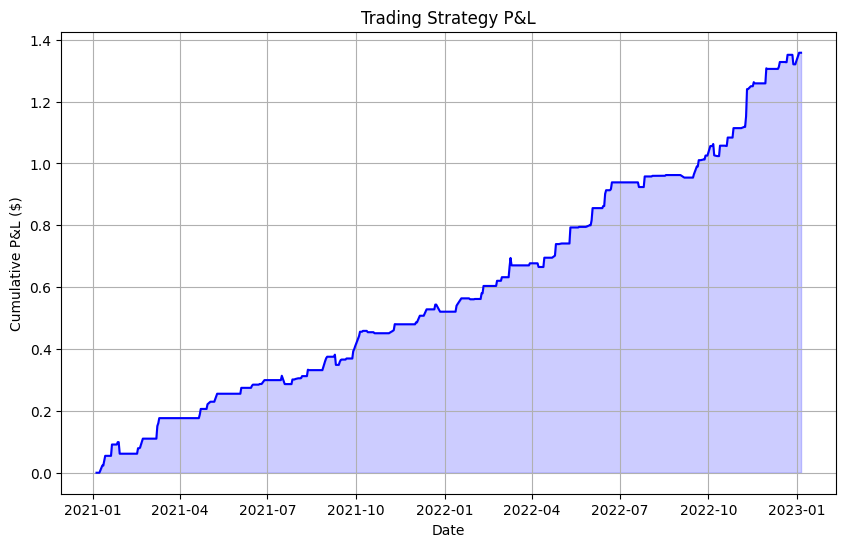

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["Cumulative_PnL"], label='Cumulative P&L', color='b')
plt.fill_between(data.index, data["Cumulative_PnL"], color='b', alpha=0.2)
plt.xlabel("Date")
plt.ylabel("Cumulative P&L ($)")
plt.title("Trading Strategy P&L")
plt.grid(True)

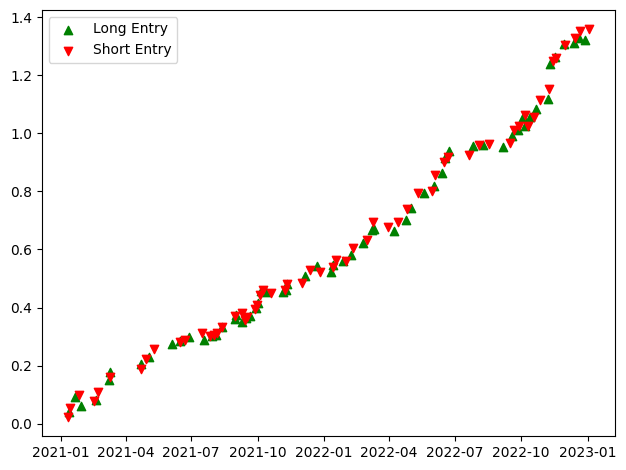

In [ ]:
long_entry = data[data["Position"] == 1]
short_entry = data[data["Position"] == -1]
plt.scatter(long_entry.index, long_entry["Cumulative_PnL"], marker='^', color='g', label='Long Entry')
plt.scatter(short_entry.index, short_entry["Cumulative_PnL"], marker='v', color='r', label='Short Entry')
plt.legend()
plt.tight_layout()
plt.show()
